A notebook for visualizing the various space filling curves implemented for the thesis. Also compares the two methods for generalizing the sfc's to arbitrary images, and the hamiltonian path generation for those curves.

We start by importing the `space_filling_curves.py` module

In [30]:
import sys
sys.path.append('..')

from src.curves.space_filling_curves import *
import matplotlib.pyplot as plt
import numpy as np

Visualise all the curves of order 1 to 3 on the unit square

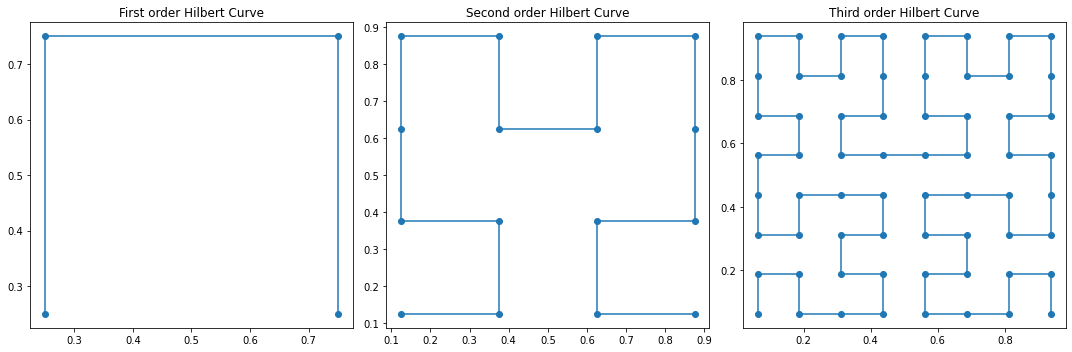

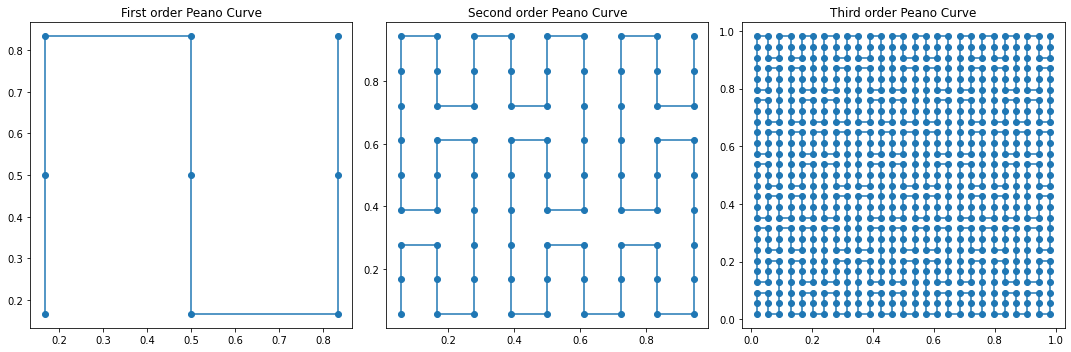

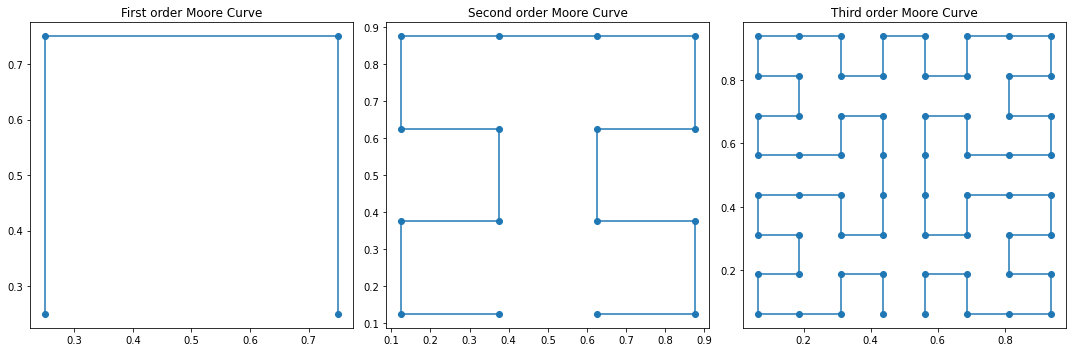

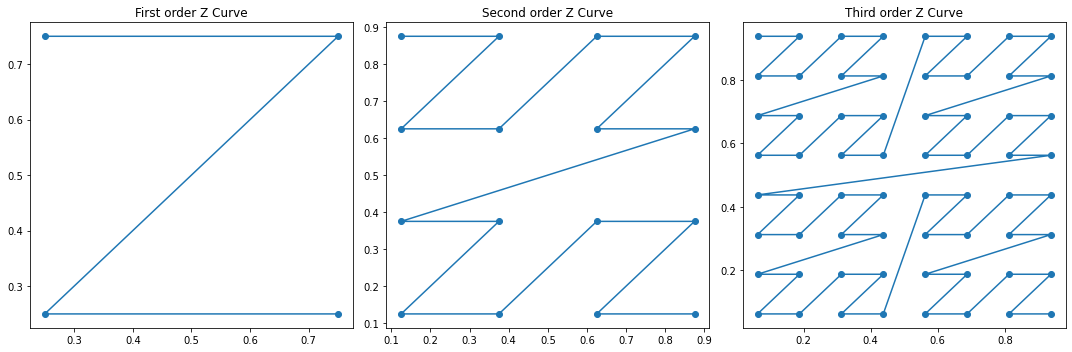

In [ ]:
def visualise_sfc(sfc, orders):
    _, ax = plt.subplots(1, len(orders), figsize=(15, 5))
    for i, o in enumerate(orders):
        hilbert = sfc(o, 1)  # Assume this returns a list of (x, y) tuples
        name = ' '.join(word.capitalize() for word in sfc.__name__.split('_'))
        x, y = zip(*hilbert)  # unzip into x and y coordinates
        ax[i].plot(x, y, marker='o')
        prefix = "First" if o == 1 else "Second" if o == 2 else "Third"
        ax[i].set_title(f"{prefix} order {name}")

    plt.tight_layout()
    plt.show()

order = [1, 2, 3]
visualise_sfc(hilbert_curve, order)
visualise_sfc(peano_curve, order)
visualise_sfc(moore_curve, order)
visualise_sfc(z_curve, order)
visualise_sfc(onion_curve, order)